## Ensemble Learning Model to Predict Credit Card Fraud

### Dataset from Kaggle contains 284,807 examples with 31 features.

##### Import Pandas, Numpy, Matplotlib, and various Scitkit Learn libraries

In [47]:
%matplotlib inline

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import os
import pandas as pd
import numpy as np
import seaborn as sns
import keras
import itertools
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
import matplotlib.patches as mpatches
from imblearn.under_sampling import NearMiss
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
from imblearn.over_sampling import SMOTE
from keras import backend as backend
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

# Accuracy Measurements
from sklearn.metrics import accuracy_score, recall_score, precision_score, precision_recall_curve
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, confusion_matrix, classification_report
from sklearn import metrics as metrics
from scipy.stats import skew, norm
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV
from imblearn.metrics import classification_report_imbalanced

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier

# Clustering
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD

##### Load Dataset from csv file

In [3]:
CREDIT_FRAUD_PATH = os.path.join("dataset", "creditcardfraud")

if not os.path.isdir(CREDIT_FRAUD_PATH):
    os.makedirs(CREDIT_FRAUD_PATH)

def load_credit_fraud_data(credit_fraud_path=CREDIT_FRAUD_PATH):
    csv_path = os.path.join(credit_fraud_path, "creditcard.csv")
    
    return pd.read_csv(csv_path, float_precision='round_trip')

credit_fraud = load_credit_fraud_data()

##### Visualize the Data

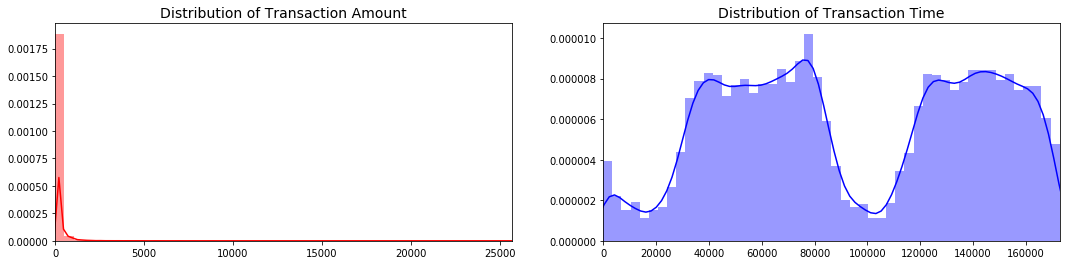

In [4]:
#credit_fraud.hist(bins=50, figsize=(15,15))
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = credit_fraud['Amount'].values
time_val = credit_fraud['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

### Scale 'Amount' and 'Time'as they are the only attributes which haven't been scaled yet
##### Standard Scaler assumes your data is normally distributed within each feature and will scale them such that the distribution is now centered around 0. Because our data is not normally distributed, this isn't the best scaler to use.
##### Min-max scaler works well when the standard deviation is small, but is sensitive to outliers.
##### Robust Scaler uses interquartile range which is robust to outliers

##### Before we decide which scaler to use, lets look at the boxplots to see the outlier situation.

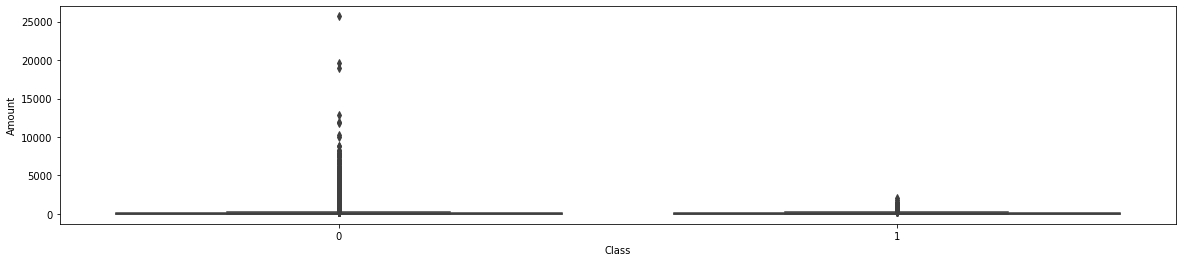

In [5]:
f, ax = plt.subplots(figsize=(20, 4))
sns.boxplot(x="Class", y="Amount", data=credit_fraud, ax=ax)

plt.show()

##### As we can see there are many outliers so it would be best to use RobustScaler.

In [6]:
robust_scaler = RobustScaler()

credit_fraud['scaled_amount'] = robust_scaler.fit_transform(credit_fraud['Amount'].values.reshape(-1, 1))
credit_fraud['scaled_time'] = robust_scaler.fit_transform(credit_fraud['Time'].values.reshape(-1,1))
credit_fraud.drop(['Time', 'Amount'], axis=1, inplace=True)

scaled_amount = credit_fraud['scaled_amount']
scaled_time = credit_fraud['scaled_time']
credit_fraud.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
credit_fraud.insert(0, 'scaled_amount', scaled_amount)
credit_fraud.insert(1, 'scaled_time', scaled_time)

#### Split the data up using Stratified K-fold Cross Validation

In [7]:
credit_X = credit_fraud.drop('Class', axis=1)
credit_y = credit_fraud['Class']

strat_k_split = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in strat_k_split.split(credit_X, credit_y):
    original_X_train, original_X_test = credit_X.iloc[train_index], credit_X.iloc[test_index]
    original_y_train, original_y_test = credit_y.iloc[train_index], credit_y.iloc[test_index]
    
original_Xtrain = original_X_train.values
original_Xtest = original_X_test.values
original_ytrain = original_y_train.values
original_ytest = original_y_test.values

##### Check the label distribution 

[0.99827076 0.00172924]
[0.99827952 0.00172048]


Text(0.5, 1.0, 'Class Distributions')

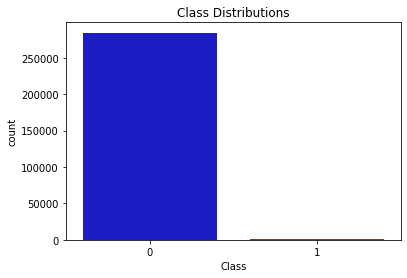

In [8]:
train_unique_labels, train_counts_labels = np.unique(original_y_train, return_counts=True)
test_unique_labels, test_counts_labels = np.unique(original_y_test, return_counts=True)

print(train_counts_labels / len(original_y_train))
print(test_counts_labels / len(original_y_test))

colors = ["#0101DF", "#DF0101"]
sns.countplot('Class', data=credit_fraud, palette=colors)
plt.title("Class Distributions")

### Random Undersampling
##### Removing data to produce a more balanced dataset

Text(0.5, 1.0, 'Class Distributions')

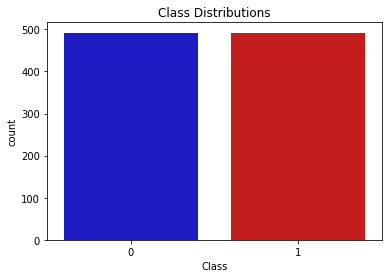

In [9]:
# Shuffle the data
credit_fraud = credit_fraud.sample(frac=1)

# Determine how many instances of fraud vs. not fraud.
num_fraud, num_non_fraud = credit_fraud["Class"].value_counts()
fraud_instances = credit_fraud.loc[credit_fraud["Class"] == 1]
non_fraud = credit_fraud.loc[credit_fraud["Class"] == 0][:num_non_fraud]

# Concatenate the balanced fraud and non fraud instances 
normal_distributed_credit_fraud = pd.concat([fraud_instances, non_fraud])

# Shuffle the concatenated values
credit_bal = normal_distributed_credit_fraud.sample(frac=1, random_state=42)
credit_bal.head()

# Check the label distributions
sns.countplot('Class', data=credit_bal, palette=colors)
plt.title("Class Distributions")

#### Correlations

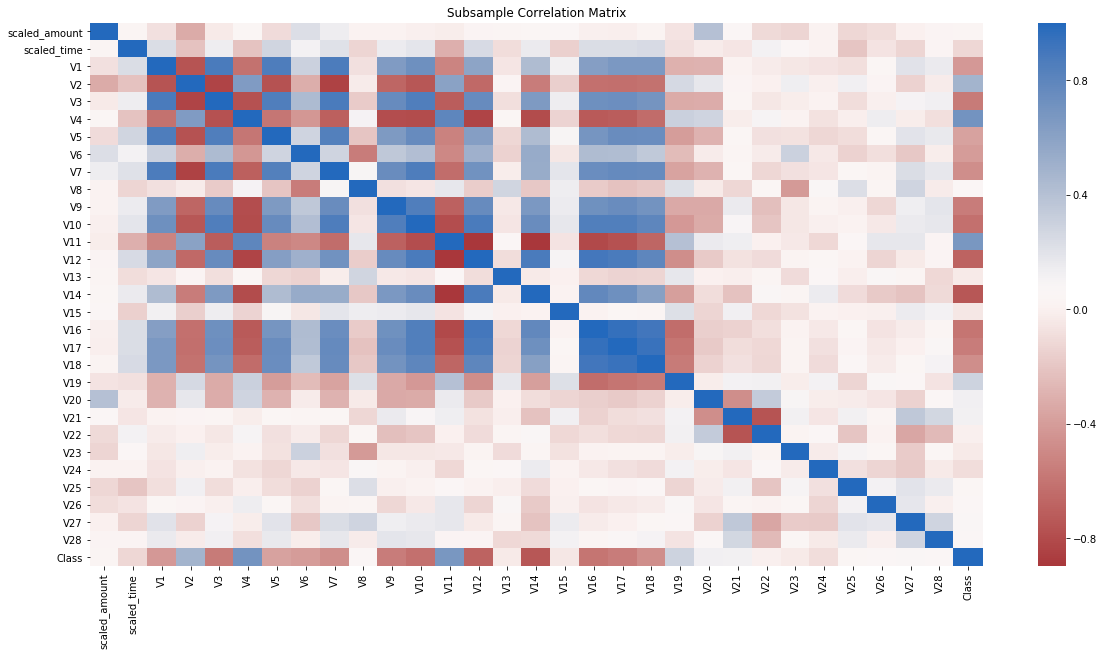

In [10]:
fig, ax1 = plt.subplots(1, 1, figsize=(20, 10))

correlation = credit_bal.corr()
sns.heatmap(data=correlation, cmap='vlag_r', ax=ax1)
ax1.set_title("Subsample Correlation Matrix")

plt.show()

#### Use boxplots to display quartiles and outliers on highly correlated features

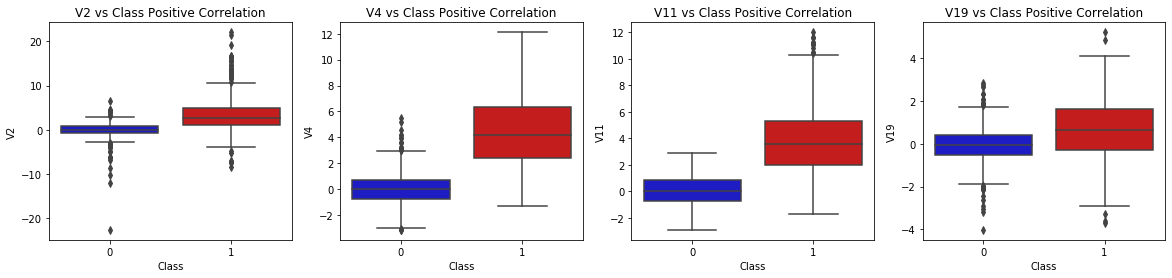

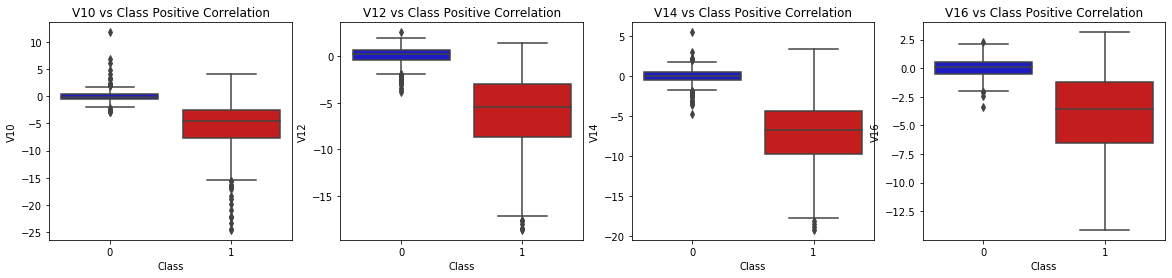

In [11]:
correlated_features = ['V2', 'V4', 'V11', 'V19']
correlated_features_negative = ['V10', 'V12', 'V14', 'V16']

# Positive Correlations
fig, axes = plt.subplots(ncols=4, figsize=(20, 4))

sns.boxplot(x='Class', y='V2', data=credit_bal, palette=colors, ax=axes[0])
axes[0].set_title("V2 vs Class Positive Correlation")

sns.boxplot(x='Class', y='V4', data=credit_bal, palette=colors, ax=axes[1])
axes[1].set_title("V4 vs Class Positive Correlation")

sns.boxplot(x='Class', y='V11', data=credit_bal, palette=colors, ax=axes[2])
axes[2].set_title("V11 vs Class Positive Correlation")

sns.boxplot(x='Class', y='V19', data=credit_bal, palette=colors, ax=axes[3])
axes[3].set_title("V19 vs Class Positive Correlation")

plt.show()


# Negative Correlations

fig, axes = plt.subplots(ncols=4, figsize=(20, 4))

sns.boxplot(x='Class', y='V10', data=credit_bal, palette=colors, ax=axes[0])
axes[0].set_title("V10 vs Class Positive Correlation")

sns.boxplot(x='Class', y='V12', data=credit_bal, palette=colors, ax=axes[1])
axes[1].set_title("V12 vs Class Positive Correlation")

sns.boxplot(x='Class', y='V14', data=credit_bal, palette=colors, ax=axes[2])
axes[2].set_title("V14 vs Class Positive Correlation")

sns.boxplot(x='Class', y='V16', data=credit_bal, palette=colors, ax=axes[3])
axes[3].set_title("V16 vs Class Positive Correlation")

plt.show()

#### Visualize Distributions

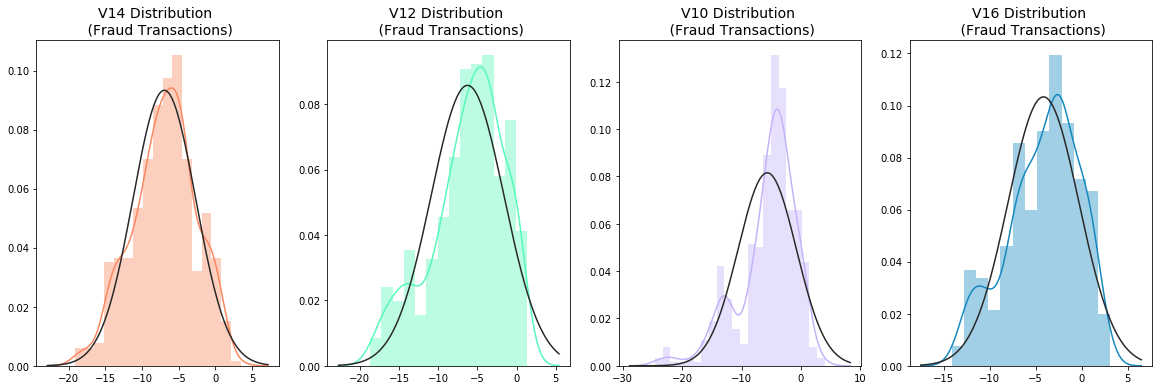

In [12]:
fig, axes = plt.subplots(1, 4, figsize=(20, 6))

v14_fraud_dist = credit_bal['V14'].loc[credit_bal['Class'] == 1].values
sns.distplot(v14_fraud_dist,ax=axes[0], fit=norm, color='#FB8861')
axes[0].set_title('V14 Distribution \n (Fraud Transactions)', fontsize=14)

v12_fraud_dist = credit_bal['V12'].loc[credit_bal['Class'] == 1].values
sns.distplot(v12_fraud_dist,ax=axes[1], fit=norm, color='#56F9BB')
axes[1].set_title('V12 Distribution \n (Fraud Transactions)', fontsize=14)

v10_fraud_dist = credit_bal['V10'].loc[credit_bal['Class'] == 1].values
sns.distplot(v10_fraud_dist,ax=axes[2], fit=norm, color='#C5B3F9')
axes[2].set_title('V10 Distribution \n (Fraud Transactions)', fontsize=14)

v16_fraud_dist = credit_bal['V16'].loc[credit_bal['Class'] == 1].values
sns.distplot(v16_fraud_dist,ax=axes[3], fit=norm, color='#1688BF')
axes[3].set_title('V16 Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

#### Remove Outliers

In [13]:
feature_names = ['V10', 'V12', 'V14', 'V16', 'V2', 'V4', 'V11', 'V19']

v2_fraud_dist = credit_bal['V2'].loc[credit_bal['Class'] == 1].values
v4_fraud_dist = credit_bal['V4'].loc[credit_bal['Class'] == 1].values
v11_fraud_dist = credit_bal['V11'].loc[credit_bal['Class'] == 1].values
v19_fraud_dist = credit_bal['V19'].loc[credit_bal['Class'] == 1].values

features_with_outliers = [v10_fraud_dist, v12_fraud_dist, v14_fraud_dist, v16_fraud_dist,
                         v2_fraud_dist, v4_fraud_dist, v11_fraud_dist, v19_fraud_dist]

def remove_outliers(dataset, outliers_to_remove, names):
    for i in range(len(outliers_to_remove)):
        feature = outliers_to_remove[i]
        name = names[i]
        print(name)
        q25, q75 = np.percentile(feature, 25), np.percentile(feature, 75)
        interquartile_rng = q75 - q25
        cutoff = interquartile_rng * 1.5
        feature_lower, feature_upper = q25 - cutoff, q75 + cutoff  
        print("IQR:", interquartile_rng)
        print("Cutoff: ", cutoff, "\n")
        print("Upper: ", feature_upper)
        print("Lower: ", feature_lower, "\n")
        outliers = [x for x in feature if x < feature_lower or x > feature_upper]
        print(name + ' outliers:{}'.format(outliers), "\n")
        print('Feature ' + name + ' Outliers for Fraud Cases: {}'.format(len(outliers)), "\n \n")
        
        dataset = dataset.drop(dataset[(dataset[name] > feature_upper) | (dataset[name] < feature_lower)].index)
        credit_bal = dataset
    return dataset

credit_bal = remove_outliers(credit_bal, features_with_outliers, feature_names)

V10
IQR: 5.142514314657911
Cutoff:  7.713771471986866 

Upper:  5.099587558797303
Lower:  -15.47046969983434 

V10 outliers:[-22.1870885620007, -22.1870885620007, -16.2556117491401, -18.2711681738888, -16.6011969664137, -22.1870885620007, -16.7460441053944, -23.2282548357516, -19.836148851696, -17.1415136412892, -24.4031849699728, -16.6496281595399, -15.5637913387301, -16.3035376590131, -18.9132433348732, -20.9491915543611, -24.5882624372475, -15.5637913387301, -22.1870885620007] 

Feature V10 Outliers for Fraud Cases: 19 
 

V12
IQR: 5.714088496427376
Cutoff:  8.571132744641064 

Upper:  5.597044719256134
Lower:  -17.25930926645337 

V12 outliers:[-18.5536970096458, -17.6316063138707, -18.0475965708216, -18.6837146333443, -17.7691434633638, -18.4311310279993] 

Feature V12 Outliers for Fraud Cases: 6 
 

V14
IQR: 5.409902115485519
Cutoff:  8.114853173228278 

Upper:  3.8320323237414122
Lower:  -17.807576138200663 

V14 outliers:[-18.8220867423816, -19.2143254902614, -18.4937733551053,

#### View boxplots to check out outlier removal changes

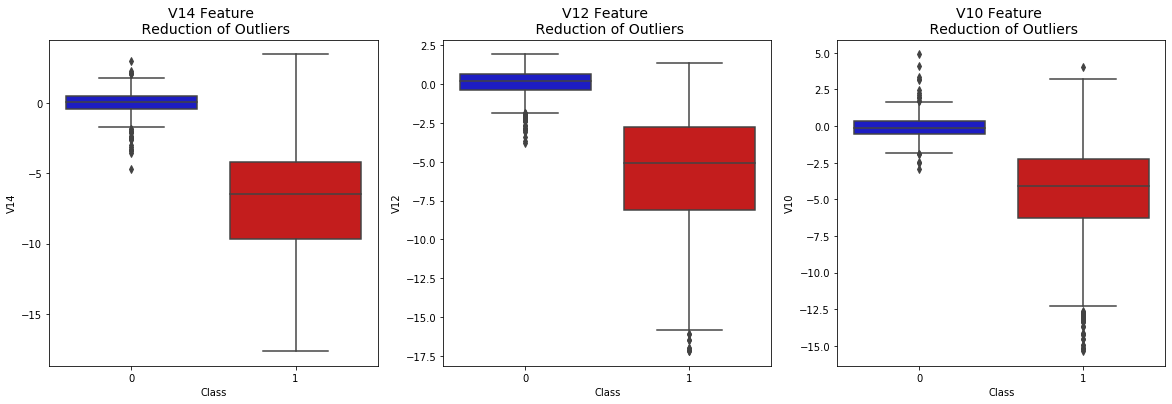

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

sns.boxplot(x="Class", y="V14", data=credit_bal, ax=axes[0], palette=colors)
axes[0].set_title("V14 Feature \n Reduction of Outliers", fontsize=14)

sns.boxplot(x="Class", y="V12", data=credit_bal, ax=axes[1], palette=colors)
axes[1].set_title("V12 Feature \n Reduction of Outliers", fontsize=14)

sns.boxplot(x="Class", y="V10", data=credit_bal, ax=axes[2], palette=colors)
axes[2].set_title("V10 Feature \n Reduction of Outliers", fontsize=14)

plt.show()

### Clustering Algorithms
##### t-SNE, PCA, and Truncated SVD

In [15]:
X = credit_bal.drop('Class', axis=1)
y = credit_bal['Class']

X_reduced_tsne = TSNE(random_state=42).fit_transform(X.values)

X_reduced_pca = PCA(random_state=42).fit_transform(X.values)

X_reduced_svd = TruncatedSVD(algorithm='randomized', random_state=42).fit_transform(X.values)

#### Visualize Clusters

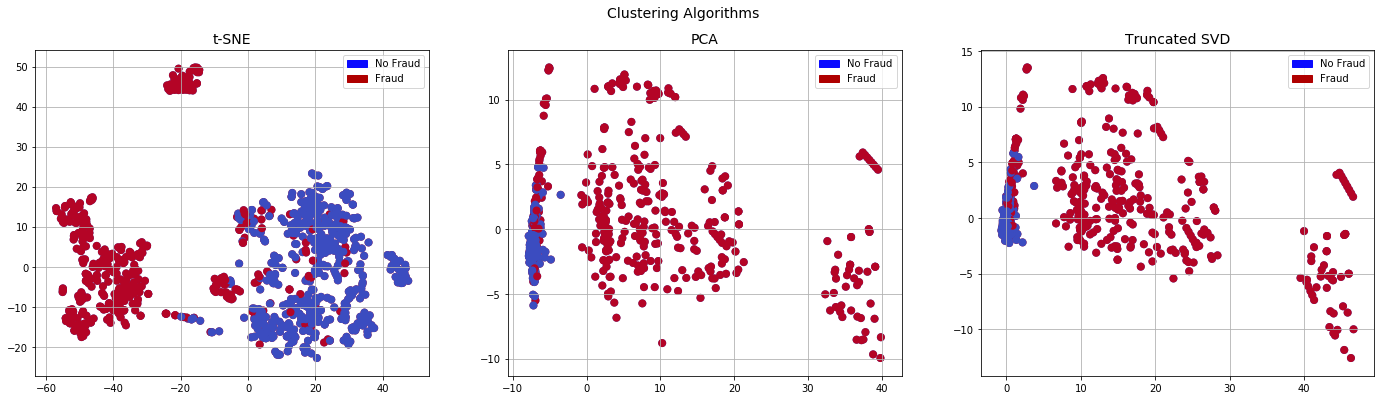

In [16]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
f.suptitle('Clustering Algorithms', fontsize=14)

blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')

# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()

### Classification

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

classifier_pairs = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier()
}

for type, classifier in classifier_pairs.items():
    classifier.fit(X_train, y_train)
    train_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifier " + classifier.__class__.__name__, "has training score: ", round(train_score.mean(), 2) * 100)

Classifier LogisticRegression has training score:  92.0
Classifier KNeighborsClassifier has training score:  92.0
Classifier SVC has training score:  92.0
Classifier DecisionTreeClassifier has training score:  89.0
Classifier RandomForestClassifier has training score:  91.0


### Use GridSearch to find the best parameters
##### Create the grid search parameters for each classifier

In [19]:
logistic_reg_params = [{"penalty": ['l1'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 
                       'solver': ['liblinear', 'saga']},
                       {"penalty": ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                       'solver': ['newton-cg', 'sag', 'lbfgs']},
                       {"penalty": ['elasticnet'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                       'solver': ['saga'], 'l1_ratio': [0, 0.25, 0.5, 0.75, 1]}
                      ]

log_reg_grid = GridSearchCV(LogisticRegression(), logistic_reg_params)
log_reg_grid.fit(X_train, y_train)

log_reg = log_reg_grid.best_estimator_

knears_params = {"n_neighbors": [1, 4, 7, 10, 13, 16, 19, 22], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 
                  'weights': ['uniform', 'distance']}

knears_grid = GridSearchCV(KNeighborsClassifier(), knears_params)
knears_grid.fit(X_train, y_train)
knears_neighbors = knears_grid.best_estimator_

svc_params = {'C': [0.001, 0.01, 0.5, 0.7, 0.9, 1, 1.25, 1.5, 10, 100], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear'],
             'shrinking': [True, False], 'decision_function_shape': ['ovo', 'ovr'], 'probability': [True]}
svc_grid = GridSearchCV(SVC(), svc_params)
svc_grid.fit(X_train, y_train)
svc = svc_grid.best_estimator_

tree_params = {'criterion': ["gini", "entropy"], 'splitter': ["best", "random"], 'min_samples_leaf': list(range(1, 11, 1)),
              'class_weight': ["balanced", None], 'presort': [True, False]}
tree_grid = GridSearchCV(DecisionTreeClassifier(), tree_params)
tree_grid.fit(X_train, y_train)
tree = tree_grid.best_estimator_

# Add more estimators back in
random_for_params = {'n_estimators': [5, 10, 50, 100], 'criterion': ["gini", "entropy"], 'min_samples_leaf': list(range(1, 11, 1)),
                    'max_features': [None, "auto", "log2"], 'bootstrap': [False, True], 'class_weight': ["balanced", "balanced_subsample", None]}
forest_grid = GridSearchCV(RandomForestClassifier(), random_for_params)
forest_grid.fit(X_train, y_train)
forest = forest_grid.best_estimator_

#### Undersampling during cross validation using Near Miss Technique

In [20]:
undersample_X = credit_fraud.drop('Class', axis=1)
undersample_y = credit_fraud['Class']

for train_index, test_index in strat_k_split.split(undersample_X, undersample_y):
    undersample_Xtrain, undersample_Xtest = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
    undersample_ytrain, undersample_ytest = undersample_y.iloc[train_index], undersample_y.iloc[test_index]

undersample_Xtrain = undersample_Xtrain.values
undersample_Xtest = undersample_Xtest.values
undersample_ytrain = undersample_ytrain.values
undersample_ytest = undersample_ytest.values     

undersmp_acc = []
undersmp_prec = []
undersmp_rec = []
undersmp_f1 = []
undersmp_auc = []

X_nearmiss, y_nearmiss = NearMiss().fit_sample(undersample_X.values, undersample_y.values)
classifiers = [log_reg, knears_neighbors, svc, tree, forest]

# Cross Validate
for train, test in strat_k_split.split(undersample_Xtrain, undersample_ytrain):
    for i in range(len(classifiers)):
        undersample_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), classifiers[i])
        undersample_model = undersample_pipeline.fit(undersample_Xtrain[train], undersample_ytrain[train])
        undersample_pred = undersample_model.predict(undersample_Xtrain[test])

        undersmp_acc.append(undersample_pipeline.score(original_Xtrain[test], original_ytrain[test]))
        undersmp_prec.append(precision_score(original_ytrain[test], undersample_pred))
        undersmp_rec.append(recall_score(original_ytrain[test], undersample_pred))
        undersmp_f1.append(f1_score(original_ytrain[test], undersample_pred))
        undersmp_auc.append(roc_auc_score(original_ytrain[test], undersample_pred))    
        
scores = [undersmp_acc, undersmp_prec, undersmp_rec, undersmp_f1, undersmp_auc]

#### Display Prediction Accuracy

In [21]:
classifier_names = ["Logistic Regression", "K Nearest Neighbors", "SVC", "Decision Tree", "Random Forest"]
measurement_names = ["Accuracy", "Precision", "Recall", "F1", "AUC"]
def display_prediction_accuracy(scores, names, classifiers):
    for i in range(len(scores)):
        measurement = scores[i]
        name = names[i]
        sum_score = 0
        for y in range(len(classifiers)):
            classifier_name = classifiers[y]
            print(classifier_name + " " + name + " Score: ", np.mean(measurement[y]))
            sum_score += np.mean(measurement[y])
        average_score = sum_score / len(classifiers) 
        print("\n")
        print("Average Score: ", average_score)
        print("\n \n")
            
display_prediction_accuracy(scores, measurement_names, classifier_names)

Logistic Regression Accuracy Score:  0.5529734474434935
K Nearest Neighbors Accuracy Score:  0.5317972350230414
SVC Accuracy Score:  0.8803598858898398
Decision Tree Accuracy Score:  0.44507351327627825
Random Forest Accuracy Score:  0.16442835198595568


Average Score:  0.5149264867237218

 

Logistic Regression Precision Score:  0.0031566486913060634
K Nearest Neighbors Precision Score:  0.0024323682961556715
SVC Precision Score:  0.0017817371937639199
Decision Tree Precision Score:  0.002976190476190476
Random Forest Precision Score:  0.0029629211580788984


Average Score:  0.002661973163099006

 

Logistic Regression Recall Score:  0.3380281690140845
K Nearest Neighbors Recall Score:  0.2887323943661972
SVC Recall Score:  0.056338028169014086
Decision Tree Recall Score:  0.528169014084507
Random Forest Recall Score:  0.7394366197183099


Average Score:  0.39014084507042257

 

Logistic Regression F1 Score:  0.006254886630179828
K Nearest Neighbors F1 Score:  0.004824096952582656
SV

### Plot Learning Curves

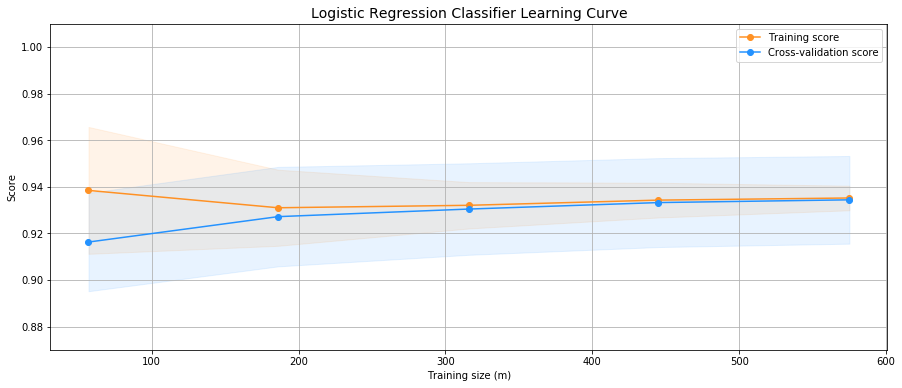

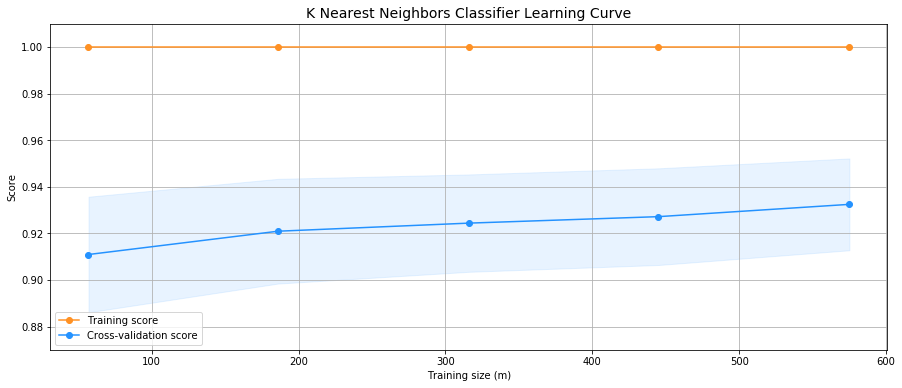

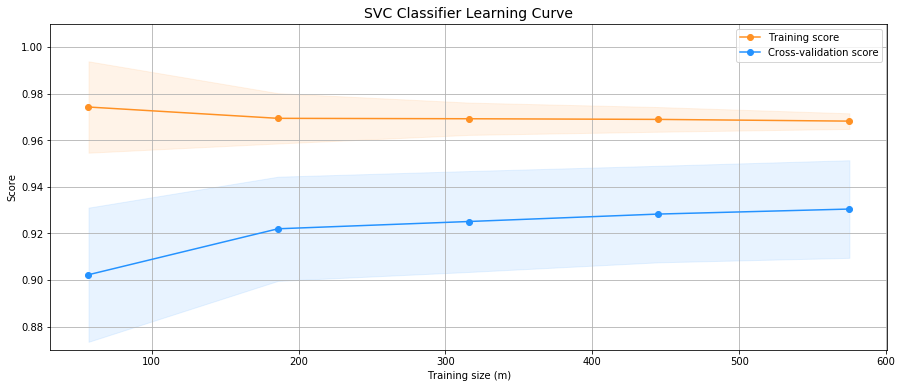

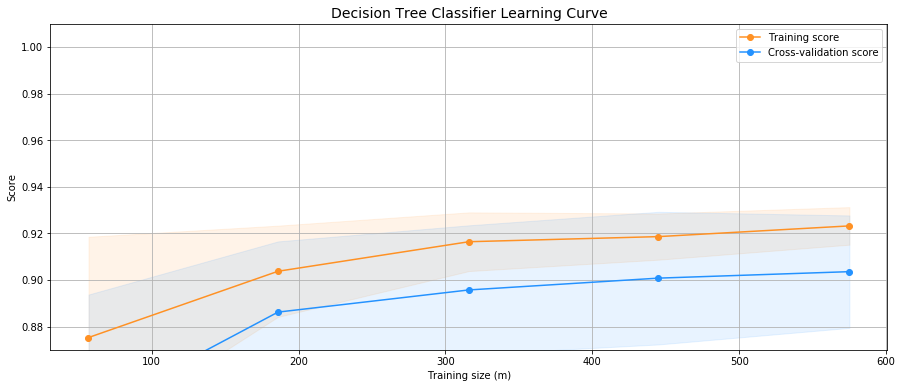

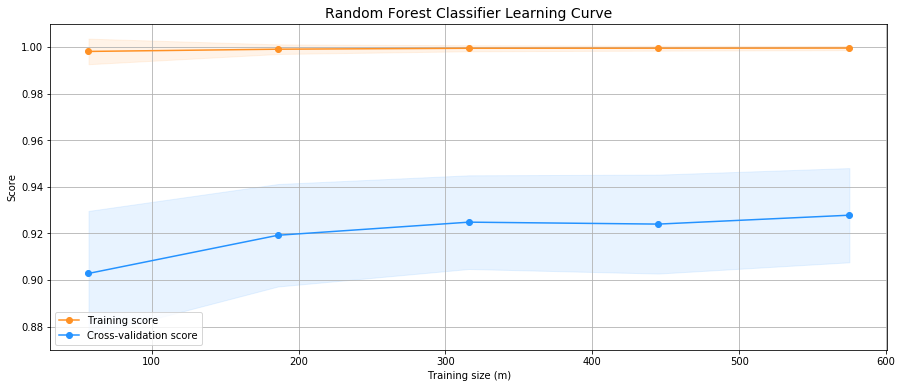

In [22]:
def plot_learning_curve(estimator1, name, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, ax1 = plt.subplots(1,1, figsize=(15,6), sharey=True)
    if ylim is not None:
        plt.ylim(*ylim)
        
    # First Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    
    ax1.set_title(name + " Classifier Learning Curve", fontsize=14)
    ax1.set_xlabel('Training size (m)')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")
    
    return plt

cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
for i in range(len(classifiers)):
    estimator = classifiers[i]
    plot = plot_learning_curve(estimator, classifier_names[i], X_train, y_train, (0.87, 1.01), cv=cv, n_jobs=1)
    plot.show()

### Display ROC AUC Curves

In [23]:
log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5, method="decision_function")

knears_pred = cross_val_predict(knears_neighbors, X_train, y_train, cv=5)

svc_pred = cross_val_predict(svc, X_train, y_train, cv=5, method="decision_function")

tree_pred = cross_val_predict(tree, X_train, y_train, cv=5)

forest_pred = cross_val_predict(forest, X_train, y_train, cv=5)

classifier_predictions = [log_reg_pred, knears_pred, svc_pred, tree_pred, forest_pred]

for i in range(len(classifiers)):
    name = classifier_names[i]
    print(name + ": ", roc_auc_score(y_train, classifier_predictions[i]))

Logistic Regression:  0.9717575983475438
K Nearest Neighbors:  0.9250803708708009
SVC:  0.963184705462113
Decision Tree:  0.8797465405581699
Random Forest:  0.9199979810216031


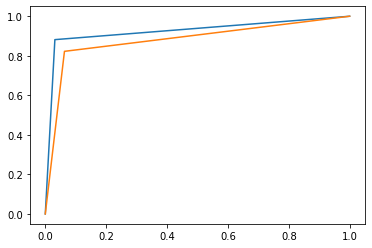

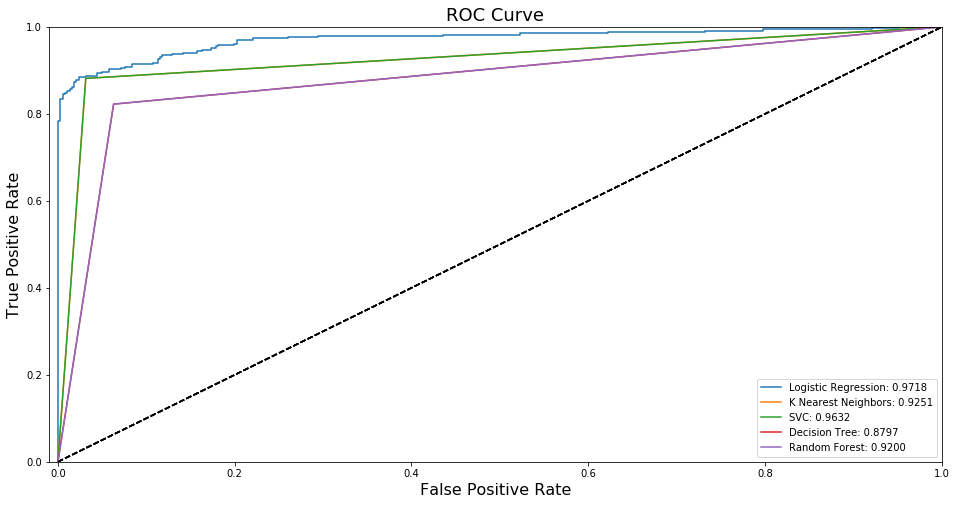

In [24]:
log_fpr, log_tpr, log_threshold = roc_curve(y_train, log_reg_pred)
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_train, knears_pred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_train, knears_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_train, tree_pred)
forest_fpr, forest_tpr, forest_threshold = roc_curve(y_train, tree_pred)
curves = [[log_fpr, log_tpr], [knear_fpr, knear_tpr], [svc_fpr, svc_tpr], [tree_fpr, tree_tpr], [forest_fpr, forest_tpr]]

def graph_roc_curve_multiple(curves, names):
    plt.figure(figsize=(16, 8))
    plt.title("ROC Curve", fontsize=18)
    for i in range(len(curves)):
        classifier = curves[i]
        fpr = classifier[0]
        tpr = classifier[1]
        auc = roc_auc_score(y_train, classifier_predictions[i])
        plt.plot(fpr, tpr, label=names[i] + ": {:.4f}".format(auc))
        plt.plot([0,1], [0,1], 'k--')
        plt.axis([-0.01, 1, 0, 1])
        plt.xlabel("False Positive Rate", fontsize=16)
        plt.ylabel("True Positive Rate", fontsize=16)
        plt.legend()

plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y_train, knears_pred)))
plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_train, tree_pred)))
graph_roc_curve_multiple(curves, classifier_names)

### Investigate Logistic Regression Further because it performs the best on the test data.
##### Implement the SMOTE Oversampling technique 

In [25]:
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
auc_list = []

for train, test in strat_k_split.split(original_X_train, original_y_train):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), log_reg)
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    best_estimator = log_reg_grid.best_estimator_
    pred = best_estimator.predict(original_Xtrain[test])
                                          
    accuracy_list.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
    precision_list.append(precision_score(original_ytrain[test], pred))
    recall_list.append(recall_score(original_ytrain[test], pred))
    f1_list.append(f1_score(original_ytrain[test], pred))
    auc_list.append(roc_auc_score(original_ytrain[test], pred))
    dictionary = {'Accuracy': accuracy_list, 'Precision':precision_list, 'Recall': recall_list, 'F1': f1_list, 'AUC': auc_list}

print("Cross Validation Predictions")
for k, v in dictionary.items():
    mean = np.mean(v)
    print(k, mean)
    
labels = ['Fraud', 'No Fraud']
smote_prediction = best_estimator.predict(original_Xtest)
print(classification_report(original_ytest, smote_prediction, target_names=labels))

Cross Validation Predictions
Accuracy 0.951024462230644
Precision 0.05992297241387443
Recall 0.9136319376825707
F1 0.1109677752125688
AUC 0.9323604566136197
              precision    recall  f1-score   support

       Fraud       1.00      0.99      0.99     56863
    No Fraud       0.10      0.86      0.18        98

    accuracy                           0.99     56961
   macro avg       0.55      0.92      0.59     56961
weighted avg       1.00      0.99      0.99     56961



#### SMOTE Technique

In [26]:
smote = SMOTE(ratio='minority', random_state=42)

Xsmote_train, ysmote_train = smote.fit_sample(original_Xtrain, original_ytrain)

##### Display Confusuon Matrix

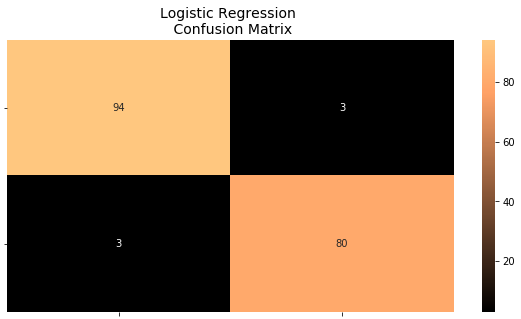

In [27]:
y_pred_log_reg = log_reg.predict(X_test)

log_reg_cf = confusion_matrix(y_test, y_pred_log_reg)

fig, ax = plt.subplots(1, 1, figsize=(10,5))

sns.heatmap(log_reg_cf, ax=ax, annot=True, cmap=plt.cm.copper)
ax.set_title("Logistic Regression \n Confusion Matrix", fontsize=14)
ax.set_xticklabels(['', ''], fontsize=14, rotation=90)
ax.set_yticklabels(['', ''], fontsize=14, rotation=360)

plt.show()

### Compare Undersampling to Oversampling

In [28]:
# Logisitic Regression with Undersampling
y_pred = log_reg.predict(X_test)
undersample_score = accuracy_score(y_test, y_pred)

# Logistic Regression with SMOTE
y_pred_sm = best_estimator.predict(original_Xtest)
oversample_score = accuracy_score(original_ytest, y_pred_sm)

scores = {'Technique': ['Random Undersampling', 'Oversampling (SMOTE)'], 'Score': [undersample_score, oversample_score]}
final_df = pd.DataFrame(data=scores)
print(final_df)

              Technique     Score
0  Random Undersampling  0.966667
1  Oversampling (SMOTE)  0.986974


### Test undersampling vs. oversampling using a neural net

#### Train undersample 

In [29]:
num_inputs = X_train.shape[1]

undersample_model = Sequential([
    Dense(num_inputs, input_shape=(num_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

Instructions for updating:
Colocations handled automatically by placer.


In [30]:
undersample_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                992       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
Total params: 1,988
Trainable params: 1,988
Non-trainable params: 0
_________________________________________________________________


In [31]:
undersample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
undersample_model.fit(X_train, y_train, validation_split=0.2, batch_size=25, epochs=20, shuffle=True, verbose=2)

Train on 575 samples, validate on 144 samples
Epoch 1/20
 - 0s - loss: 0.8804 - accuracy: 0.4452 - val_loss: 0.5408 - val_accuracy: 0.7014
Epoch 2/20
 - 0s - loss: 0.4539 - accuracy: 0.8070 - val_loss: 0.3970 - val_accuracy: 0.8611
Epoch 3/20
 - 0s - loss: 0.3497 - accuracy: 0.9026 - val_loss: 0.3387 - val_accuracy: 0.8750
Epoch 4/20
 - 0s - loss: 0.2873 - accuracy: 0.9252 - val_loss: 0.2983 - val_accuracy: 0.8681
Epoch 5/20
 - 0s - loss: 0.2405 - accuracy: 0.9287 - val_loss: 0.2719 - val_accuracy: 0.8889
Epoch 6/20
 - 0s - loss: 0.2064 - accuracy: 0.9322 - val_loss: 0.2559 - val_accuracy: 0.8819
Epoch 7/20
 - 0s - loss: 0.1813 - accuracy: 0.9409 - val_loss: 0.2458 - val_accuracy: 0.8889
Epoch 8/20
 - 0s - loss: 0.1637 - accuracy: 0.9443 - val_loss: 0.2402 - val_accuracy: 0.8889
Epoch 9/20
 - 0s - loss: 0.1502 - accuracy: 0.9461 - val_loss: 0.2428 - val_accuracy: 0.8750
Epoch 10/20
 - 0s - loss: 0.1405 - accuracy: 0.9478 - val_loss: 0.2341 - val_accuracy: 0.8819
Epoch 11/20
 - 0s - los

In [32]:
undersample_predictions = undersample_model.predict(original_Xtest, batch_size=200, verbose=0)
undersample_fraud_pred = undersample_model.predict_classes(original_Xtest, batch_size=200, verbose=0)

#### Train SMOTE (oversample)

In [33]:
num_inputs = X_train.shape[1]

oversample_model = Sequential([
    Dense(num_inputs, input_shape=(num_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

oversample_model.summary()
oversample_model.compile(optimizer=Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_5 (Dense)              (None, 32)                992       
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 66        
Total params: 1,988
Trainable params: 1,988
Non-trainable params: 0
_________________________________________________________________


In [34]:
oversample_model.fit(Xsmote_train, ysmote_train, batch_size=300, epochs=20, verbose=2, shuffle=True)

Epoch 1/20
 - 2s - loss: 0.0482 - accuracy: 0.9831
Epoch 2/20
 - 2s - loss: 0.0092 - accuracy: 0.9981
Epoch 3/20
 - 2s - loss: 0.0059 - accuracy: 0.9990
Epoch 4/20
 - 2s - loss: 0.0044 - accuracy: 0.9993
Epoch 5/20
 - 2s - loss: 0.0038 - accuracy: 0.9994
Epoch 6/20
 - 2s - loss: 0.0036 - accuracy: 0.9995
Epoch 7/20
 - 2s - loss: 0.0025 - accuracy: 0.9996
Epoch 8/20
 - 2s - loss: 0.0022 - accuracy: 0.9996
Epoch 9/20
 - 2s - loss: 0.0019 - accuracy: 0.9996
Epoch 10/20
 - 2s - loss: 0.0016 - accuracy: 0.9997
Epoch 11/20
 - 2s - loss: 0.0017 - accuracy: 0.9997
Epoch 12/20
 - 2s - loss: 0.0016 - accuracy: 0.9997
Epoch 13/20
 - 2s - loss: 0.0015 - accuracy: 0.9997
Epoch 14/20
 - 2s - loss: 0.0013 - accuracy: 0.9997
Epoch 15/20
 - 2s - loss: 0.0012 - accuracy: 0.9998
Epoch 16/20
 - 2s - loss: 0.0012 - accuracy: 0.9998
Epoch 17/20
 - 2s - loss: 9.4671e-04 - accuracy: 0.9998
Epoch 18/20
 - 2s - loss: 0.0011 - accuracy: 0.9997
Epoch 19/20
 - 2s - loss: 0.0011 - accuracy: 0.9998
Epoch 20/20
 - 2s

In [43]:
oversample_predictions = oversample_model.predict(original_Xtest, batch_size=200, verbose=0)
oversample_fraud_prediction = oversample_model.predict_classes(original_Xtest, batch_size=200, verbose=0)

### Plot Confusion Matrices

In [36]:
# Create a confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

Confusion matrix, without normalization
[[54674  2189]
 [    7    91]]
Confusion matrix, without normalization
[[56849    14]
 [   30    68]]


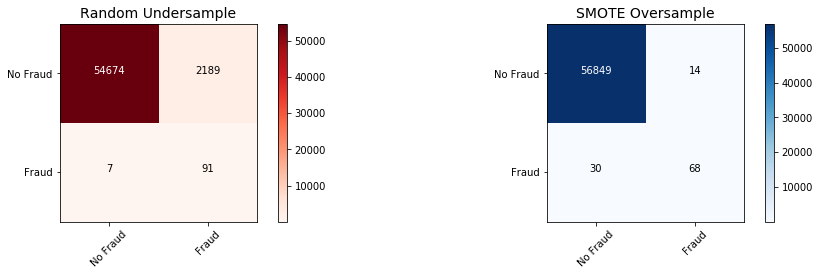

In [37]:
undersample_cm = confusion_matrix(original_ytest, undersample_fraud_pred)
labels = ['No Fraud', 'Fraud']

oversample_cm = confusion_matrix(original_ytest, oversample_fraud_prediction)

fig = plt.figure(figsize=(16, 8))

fig.add_subplot(221)
plot_confusion_matrix(undersample_cm, labels, title="Random Undersample", cmap=plt.cm.Reds)

fig.add_subplot(222)
plot_confusion_matrix(oversample_cm, labels, title="SMOTE Oversample", cmap=plt.cm.Blues)

#### From the results we see that the SMOTE oversampling technique has much better results than random undersampling. The oversampled model misclassified 40 cases whereas the random undersampling misclassified 2823 cases.

### Use a voting classifier, bagging, and boosting for prediction

##### Voting Classifier

In [46]:
# The models being put in the Voting Classifier have already been trained.
log_reg, knears_neighbors, svc, tree, forest
voting_clf = VotingClassifier(
    estimators=[('lr', log_reg), ('knears', knears_neighbors), ('svc', svc), ('dectree', tree), ('ranforest', forest)],
    voting='soft')

voting_clf.fit(X_train, y_train)

for clf in (log_reg, knears_neighbors, svc, tree, forest, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_pred, y_test))

LogisticRegression 0.9611111111111111
KNeighborsClassifier 0.95
SVC 0.9555555555555556
DecisionTreeClassifier 0.9166666666666666
RandomForestClassifier 0.9666666666666667
VotingClassifier 0.9666666666666667


##### Bagging

In [52]:
bagging_clf = BaggingClassifier(forest, n_estimators=500, 
                                bootstrap=True, n_jobs=-1, random_state=42)
bagging_clf.fit(X_train, y_train)
y_pred_bagging = bagging_clf.predict(X_test)
acc_score_bagging = accuracy_score(y_pred_bagging, y_test)
print(bagging_clf.__class__.__name__, acc_score_bagging)

BaggingClassifier 0.9611111111111111


##### Pasting (bootstrap set to False)

In [53]:
pasting_clf = BaggingClassifier(forest, n_estimators=500,
                               bootstrap=False, n_jobs=-1, random_state=42)
pasting_clf.fit(X_train, y_train)
y_pred_pasting = pasting_clf.predict(X_test)
acc_score_pasting = accuracy_score(y_pred_pasting, y_test)
print("Pasting Classifier", acc_score_pasting)

Pasting Classifier 0.9611111111111111


## ******** Previous Model Implementation ********

##### Create a train and test set. These sets may contain null values because we haven't pre-processed them yet. 
##### Because the dataset has enough training examples, we will use a 75 / 25 train test split.

In [295]:
# Add an index column to the dataset.
credit_fraud_with_id = credit_fraud.reset_index()

train_set, test_set = train_test_split(credit_fraud_with_id, train_size=0.75, random_state=42, shuffle=True)
credit_train = train_set.copy()
credit_test = test_set.copy()

##### Pre-process methods

In [296]:
def impute_median(data):
    """Imputation transformer for completing missing numerical values."""
    if isinstance(data, pd.DataFrame):
        imputer = SimpleImputer(strategy="median")
        imputer.fit(data)
        X = imputer.transform(data)
        return pd.DataFrame(X, columns=data.columns, index=data.index)
    else:
        # not a DataFrame
        return None
    
def drop_missing_values(data):
    """Drops data if there are less than 17 non-NA values in the row"""
    if isinstance(data, pd.DataFrame):
        # The row must contain at least 17 non-NA values to stay in the dataset.
        data.dropna(how="any", axis=0, thresh=17)
        return data.fillna("", inplace=False)
    else:
        # not a DataFrame
        return None
    
def log_transform(data):
    """Log Transformation for left skewed data"""
    if isinstance(data, pd.Series):
        # Check skew value. If outside of -1 to 1 range, do the log transform
        skew_value = skew(data)
        if (abs(skew_value) > 1):
            minimum = data.min()
            data_copy = data.copy()

            # Shift right to ensure all positive values
            data_copy += (-1 * minimum) + 2

            # Execute log Transform
            transformed_data = data_copy.transform(np.log)

            # Shift back left
            transformed_data += minimum - 2
            return transformed_data
        else:
            # Not skewed enough to worry about
            return data
    else:
        # not a DataFrame
        return data

##### Execute Pre-processing

In [297]:
credit_transformed = credit_fraud_with_id.copy()
features_to_transform = ["V24", "V26"]
for i in range(len(features_to_transform)):
    feature = features_to_transform[i]
    credit_transformed[feature] = log_transform(credit_transformed[feature])
    
credit_dropped = drop_missing_values(credit_transformed)
credit_fraud_imputed = impute_median(credit_fraud_with_id)

##### Stratify data

In [298]:
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)

#credit_dropped["time_attribute"] = pd.cut(credit_dropped["Time"], 
#                                       bins=[0., 35000, 70000, 105000, 140000, 175000., np.inf],
#                                       labels=[1, 2, 3, 4, 5, 6])

### Figure out scikitlearn issue here.
#for train_index, test_index in strat_split.split(credit_dropped, credit_dropped["time_attribute"]):
#    print(train_index)
#    print(test_index)
#    strat_train_set = credit_dropped.loc[train_index]
#    strat_test_set = credit_dropped.loc[test_index]

##### Visualize the data to gain insights

c:\users\grayd\onedrive\docume~1\univer~1\second~1\person~1\machin~1\neural~1\neural~1\lib\site-packages\pandas\plotting\_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


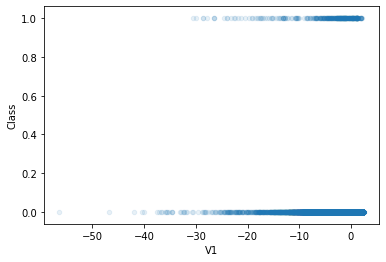

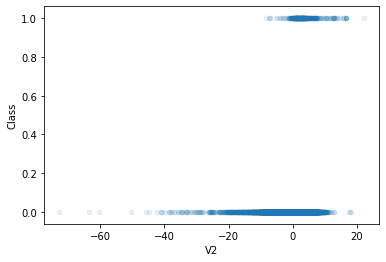

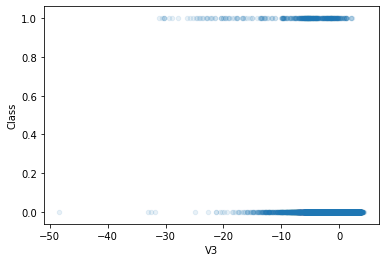

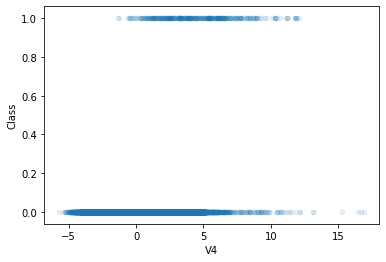

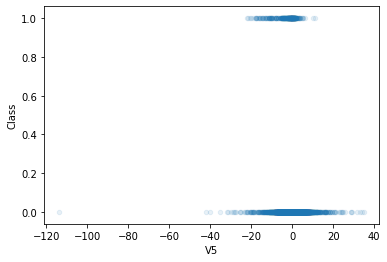

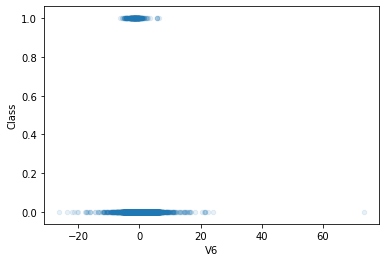

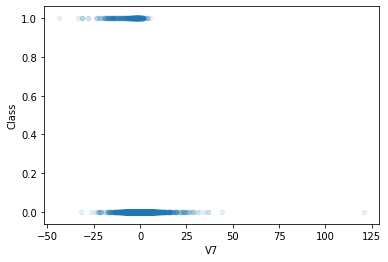

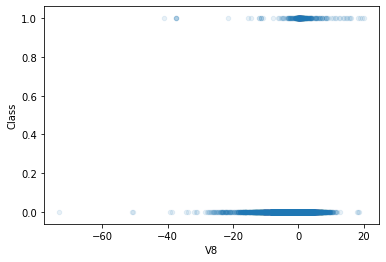

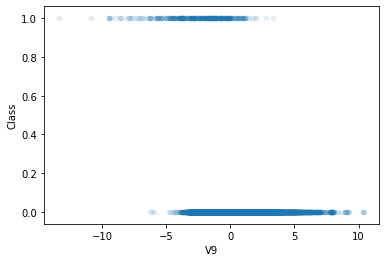

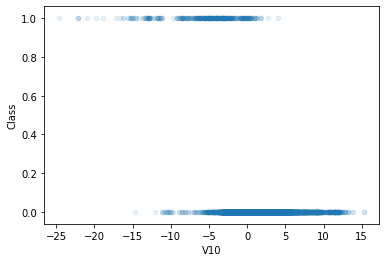

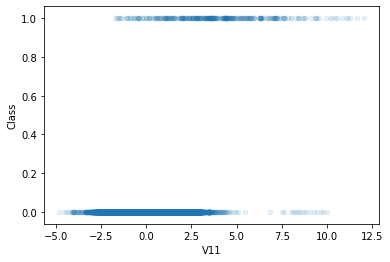

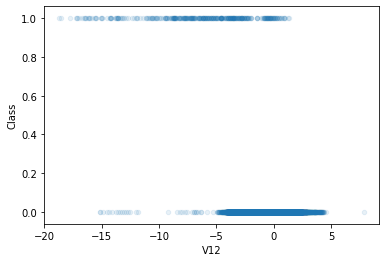

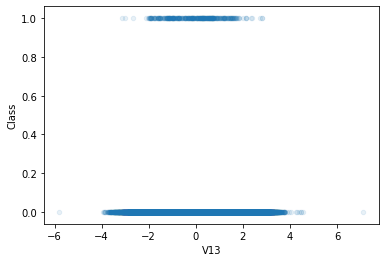

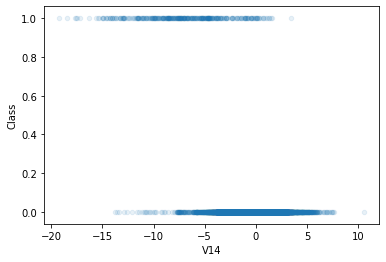

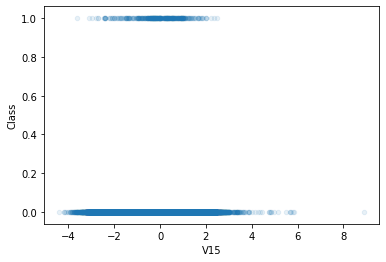

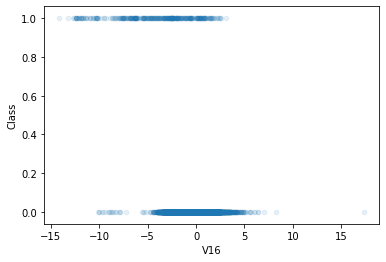

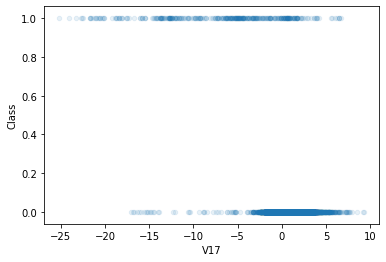

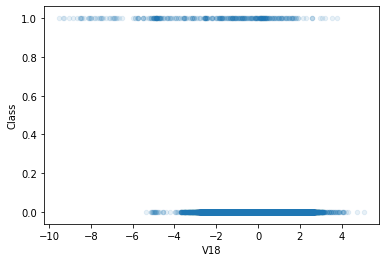

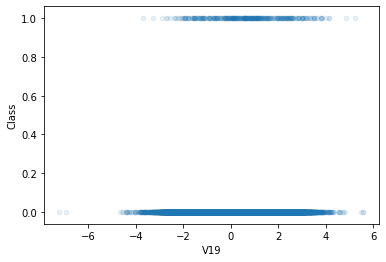

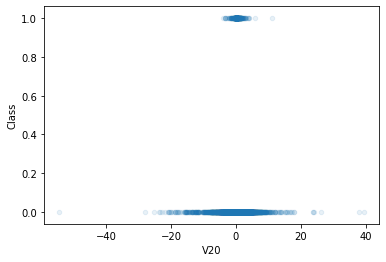

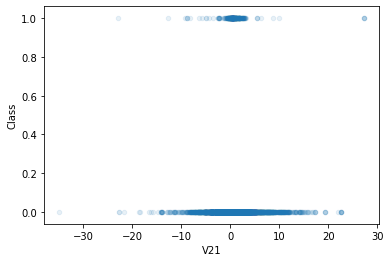

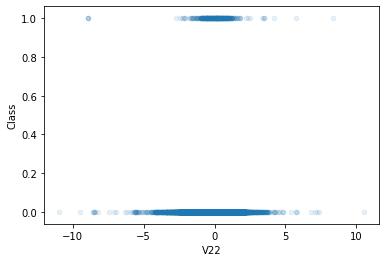

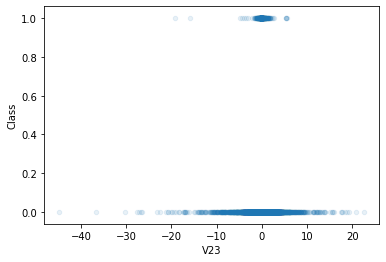

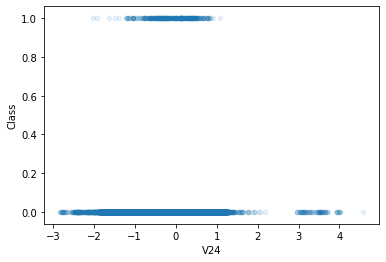

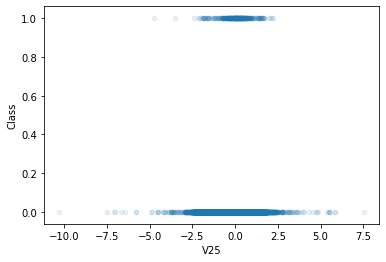

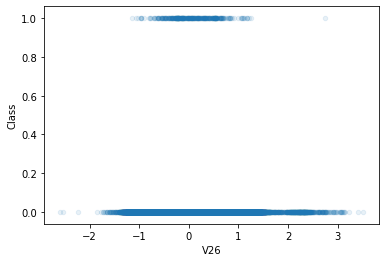

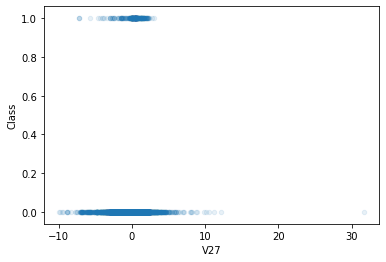

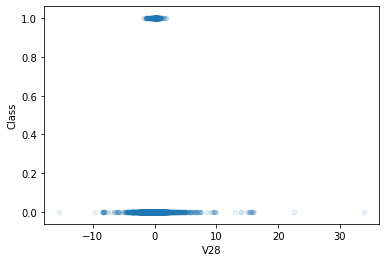

In [299]:
for i in range(28):
    feature = "V" + str(i + 1)
    credit_train.plot(kind="scatter", x=feature, y="Class", alpha="0.1")

### Look at data correlations
##### Correlation coefficient ranges from -1 to 1. When it is close to one, it means there is a string positive correlation. 
##### Example: if there is a strong positive correlation, the Class value tends to go up when the correlated attribute goes up.
##### Example: If there is a strong negative correlation, that means the Class value tends to decrease when the correlated attribute decreases. 
##### Note that the correlation coefficient only measure linear correlations! It completely misses out on any nonlinear relationships
##### We find that there aren't any strong correlations between the Class attribute and any of the features. V17 has the largest negative correlation at -0.324 and feature V11 has the largest positive correlation at 0.15.

In [300]:
corr_matrix = credit_train.corr()

##### Another way to check for correlations between attributes is to use pandas scatter_matrix() function which plots every numerical attribute against every other numerical attribute. Since there are 32 numerical attributes, we would get 32 * 32 = 1024 plots.
##### Try out a few classes below

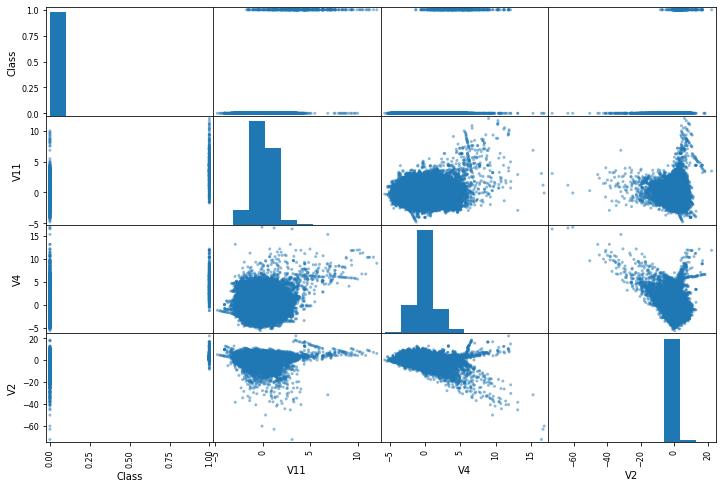

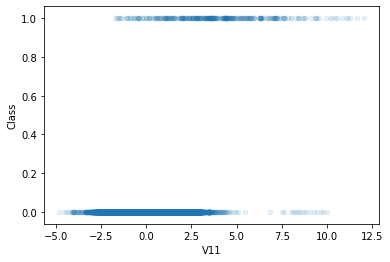

In [301]:
attributes = ["Class", "V11", "V4", "V2"]
matrix = scatter_matrix(credit_train[attributes], figsize=(12,8))
credit_train.plot(kind="scatter", x="V11", y="Class", alpha=0.1)

#### Drop label feature ('Class'), index, and time feature. 
##### The time feature is being dropped because it doesn't add any value. This was added for a metric to know when the transactions occured after each other (NOT the time of day it occured).

In [302]:
to_drop = ["Class", "index", "Time"]
credit_train_X = credit_train.drop(to_drop, axis=1)
credit_train_Y = credit_train["Class"].copy()

credit_test_X = credit_test.drop(to_drop, axis=1)
credit_test_Y = credit_test["Class"].copy()

#### Train a Random Forest with different number of trees to see accuracy results
##### ** Note ** for loop is in range 1 for faster testing

In [303]:
number_of_trees = [50, 250, 500, 750]
classifiers = []

for i in range(1):
    num_estimators = number_of_trees[i]
    rnd_forest_clf = RandomForestClassifier(n_estimators=num_estimators, n_jobs=-1, oob_score=True)
    
    # Train the random forest
    rnd_forest_clf.fit(credit_train_X, credit_train_Y)
    
    # Make predictions
    y_pred = rnd_forest_clf.predict(credit_test_X)
    
    # Generate Scores
    score = accuracy_score(credit_test_Y, y_pred)
    classifiers.append(rnd_forest_clf)
    misclassified = credit_test_Y[y_pred != credit_test_Y]
    num_test_instances = y_pred.shape[0]
    num_misclassified = misclassified.shape[0]

#### Gather results from training and testing

In [304]:
recall_score = recall_score(credit_test_Y, y_pred)
precision_score = precision_score(credit_test_Y, y_pred)
confusion_matrix = confusion_matrix(credit_test_Y, y_pred)
accuracy_score = accuracy_score(credit_test_Y, y_pred)
f1_score = f1_score(credit_test_Y, y_pred)
probabilites = rnd_forest_clf.predict_proba(credit_test_X)
predictions = probabilites[:,1]
fpr, tpr, threshold = metrics.roc_curve(credit_test_Y, predictions)
roc_auc = metrics.auc(fpr, tpr)

#### Analyze and visualize the results
##### Plot the ROC Area Under Curve Score, then display the F1 score, a confusion matrix, accuracy score, the OOB score, and finally the model accuracy.
##### ** Note ** With classification models, it is important to use testing methods other than accuracy to determine how good your model is predicting.

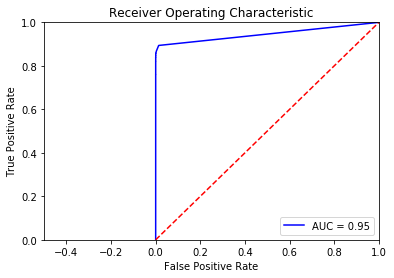

F1 Score: 0.8653846153846154
Confusion Matrix
[[71084     5]
 [   23    90]]
Accuracy Score 0.9996067526193084
Number of test instances: 71202
Number of misclassified instances: 28
Model Accuracy 0.9996067526193084
OOB Score:  0.9995037569345286


In [309]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-0.5, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

print("F1 Score:", f1_score)
print("Confusion Matrix")
print(confusion_matrix)
print("Accuracy Score", accuracy_score)
print("Number of test instances:", num_test_instances)
print("Number of misclassified instances:", num_misclassified)
print("Model Accuracy", ( (num_test_instances - num_misclassified) / num_test_instances))

for y in range(len(classifiers)):
    print("OOB Score: ", classifiers[y].oob_score_)